# RBE/CS549 Fall 2022: Computer Vision
## Homework 0: Alohomora

Author(s): 
Prof. Nitin J. Sanket (nsanket@wpi.edu), Lening Li (lli4@wpi.edu), Gejji, Vaishnavi Vivek (vgejji@wpi.edu)

Robotics Engineering Department,

Worcester Polytechnic Institute

Code adapted from CMSC733 at the University of Maryland, College Park.


## Phase 1




Phase 1 is located  at Homework0/YourDirectoryID_hw0/Phase1/Code/wrapper.py  fi

## Phase 2

# Import necessary libraries and frameworks

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torchvision
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
from torch.optim import AdamW
from torchvision.datasets import CIFAR10
import cv2
import sys
import os
import numpy as np
import random
import skimage
import PIL
import os
import glob
import time
import random
from skimage import data, exposure, img_as_float
import matplotlib.pyplot as plt
import numpy as np
from torchvision.transforms import ToTensor
from termcolor import colored, cprint
import math as m
from tqdm.notebook import tqdm
import torch.optim as optim
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split
import tarfile
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torch.utils.data.dataloader import DataLoader


Downloading the Data into directory associated with notebbok(colab)

In [3]:
"""This part of the assignment is modified, Because I was not able to upload local dataset to gdrive, error = 'No space  on drive
 I'm utilising a different copy of the same dataset from the web, but most of the functions are still utilised although some are omitted due to redundancy'"""
# Dowload the dataset
url = "https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"
download_url(url, '.')

# Extract the data from archive (tar)
with tarfile.open('./cifar10.tgz', 'r:gz') as tar:
    tar.extractall(path='./data')

#Locate dataset in the folders extracted
def ReadDirNames(ReadPath):
    """
    Inputs: 
    ReadPath is the path of the file you want to read
    Outputs:
    DirNames 
    """
    classes = os.listdir(ReadPath + "/train")
    DirNames = ImageFolder(ReadPath+'/train', transform=ToTensor())
    return DirNames


  0%|          | 0/135107811 [00:00<?, ?it/s]

In [9]:
path = './data/cifar10'
train_dataset  = ReadDirNames(path) # pytorch tensors
CLASSES = train_dataset.classes
## Improving training accuracy
# Normalizing the dataset
normalize = transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
sz = len(train_dataset)
normal = []
for i in tqdm(range(sz)):
 norm = (normalize(train_dataset[i][0]))
 normal.append(norm)
normalized = []
for i in tqdm(range(sz)):
  ds = normal[i],train_dataset[i][1]
  normalized.append(ds)
train_dataset = normalized


  0%|          | 0/50000 [00:00<?, ?it/s]

  0%|          | 0/50000 [00:00<?, ?it/s]

### Neural Network Construction

In [10]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
  
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))



class CIFAR10Model(ImageClassificationBase):
  
  def __init__(self):
    super().__init__()
      
    """
    Inputs: 
    InputSize - Size of the Input = 3
    OutputSize - Size of the Output = 10
    """
    #############################
    # Fill your network initialization of choice here!
    #############################
    # 6 convolutional layers and 3 linear
    self.network = nn.Sequential(
        nn.Conv2d(3, 32, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2, 2), 
        nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2, 2), 
        nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),
        nn.Flatten(), 
        nn.Linear(256*4*4, 1024),
        nn.ReLU(),
        nn.Linear(1024, 512),
        nn.ReLU(),
        nn.Linear(512, 10))
      
      
  def forward(self, xb):
      out = self.network(xb)
      return out

In [11]:
# Helper functions

def tic():
    """
    Function to start timer
    Tries to mimic tic() toc() in MATLAB
    """
    StartTime = time.time()
    return StartTime

def toc(StartTime):
    """
    Function to stop timer
    Tries to mimic tic() toc() in MATLAB
    """
    return time.time() - StartTime

def FindLatestModel(CheckPointPath):
    """
    Finds Latest Model in CheckPointPath
    Inputs:
    CheckPointPath - Path where you have stored checkpoints
    Outputs:
    LatestFile - File Name of the latest checkpoint
    """
    FileList = glob.glob(CheckPointPath + '*.ckpt.index') # * means all if need specific format then *.csv
    LatestFile = max(FileList, key=os.path.getctime)
    # Strip everything else except needed information
    LatestFile = LatestFile.replace(CheckPointPath, '')
    LatestFile = LatestFile.replace('.ckpt.index', '')
    return LatestFile


def convertToOneHot(vector, NumClasses):
    """
    Inputs:
    vector - vector of argmax indexes
    NumClasses - Number of classes
    """
    return np.equal.outer(vector, np.arange(NumClasses)).astype(np.float)
    
def trainingdata(Train_dataset):
  # This is just a visualization function created to verify the data
  """Input: Train_dataset - is a tensor containing 50000 images 
     and its labels(int)
     Output: train_data - numpy ndarray of data"""
  train_data = []
  for i in range(50000):
    img, label = Train_dataset[i]
    train_data.append(np.array([np.array(img),np.eye(10)[int(label)]]))
    # In the above step the label is converted to one hot vector
  np.random.shuffle(train_data) 
  return train_data

training_dataset = trainingdata(train_dataset)
label = training_dataset[0][1]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


### Train your neural network

In [12]:

# Train on GPU
model = CIFAR10Model()
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)


In [13]:
@torch.no_grad()
def evaluate(model, val_ds):
    """Input: model, validation dataset
        output: validation loss and accuracy"""
    model.eval()
    outputs = [model.validation_step(batch) for batch in tqdm(val_ds)]
    return model.validation_epoch_end(outputs)

def fit(epochs, model, train_ds, val_ds, optimizer):
    res = []
    for epoch in tqdm(range(epochs)):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_ds:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_ds)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        res.append(result)
    return res

def TrainOperation(batch_size,val_pct):
  START =tic()
  # This is a modified version of original function
  # Train the neual network
  # validation set is 10 % of the training data
  train_size = int((1-0.1)*len(train_dataset))
  # spli between train and validation dataset
  train_ds, val_ds = random_split(train_dataset, [train_size, int(len(train_dataset)-train_size)]) # train and validation dataset
  train_dset = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True) # training dataset is shuffled to ensure balance
  val_dset = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)
  
 
  # Evaluate the model
  # model = CIFAR10Model()
  # run on GPU
  device = get_default_device()
  train_dset = DeviceDataLoader(train_dset, device)
  val_dset = DeviceDataLoader(val_dset, device)
  to_device(model, device);

  evaluate(model, val_dset)
  EPOCHS =14
  optimizer = optim.Adam(model.parameters(),lr =0.001)
  train = fit(EPOCHS,model,train_dset,val_dset,optimizer)
  END = toc(START)
  print("Time to train:",round(END,3)," seconds")
  return train, model

# Train the model
batch_size = 100
valpercentage = 0.1  # validation percentage is 10%
trained, model = TrainOperation(batch_size,valpercentage)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [0], train_loss: 1.6088, val_loss: 1.2940, val_acc: 0.5236


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [1], train_loss: 1.0633, val_loss: 0.9272, val_acc: 0.6666


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [2], train_loss: 0.8011, val_loss: 0.8412, val_acc: 0.7098


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [3], train_loss: 0.6460, val_loss: 0.7356, val_acc: 0.7418


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [4], train_loss: 0.5278, val_loss: 0.6799, val_acc: 0.7628


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [5], train_loss: 0.4209, val_loss: 0.6515, val_acc: 0.7852


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [6], train_loss: 0.3337, val_loss: 0.7224, val_acc: 0.7732


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [7], train_loss: 0.2552, val_loss: 0.7920, val_acc: 0.7782


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [8], train_loss: 0.2035, val_loss: 0.8064, val_acc: 0.7836


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [9], train_loss: 0.1627, val_loss: 0.9530, val_acc: 0.7794


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [10], train_loss: 0.1312, val_loss: 0.9644, val_acc: 0.7724


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [11], train_loss: 0.1195, val_loss: 0.9806, val_acc: 0.7750


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [12], train_loss: 0.0978, val_loss: 1.0460, val_acc: 0.7958


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [13], train_loss: 0.0896, val_loss: 1.0740, val_acc: 0.7766
Time to train: 157.022  seconds


network.0.weight 32
network.0.bias 32
network.2.weight 64
network.2.bias 64
network.5.weight 128
network.5.bias 128
network.7.weight 128
network.7.bias 128
network.10.weight 256
network.10.bias 256
network.12.weight 256
network.12.bias 256
network.16.weight 1024
network.16.bias 1024
network.18.weight 512
network.18.bias 512
network.20.weight 10
network.20.bias 10


'Done'

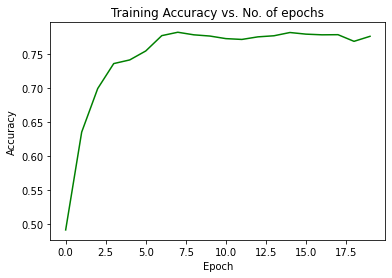

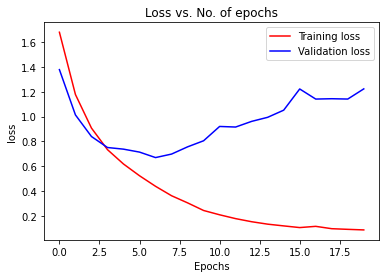

In [8]:
def report():
  # number of parameters
  for name, param in model.named_parameters():
    if param.requires_grad:
        print (name, len(param.data))
 # plot accuracy vs No.of epochs
  accuracies = [i['val_acc'] for i in trained]
  plt.figure()
  plt.plot(accuracies, '-g')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.title('Training Accuracy vs. No. of epochs');

# plot training and validation losses vs Epochs
  train_losses = [i['train_loss'] for i in trained]
  val_losses = [i['val_loss'] for i in trained]
  plt.figure()
  plt.plot(train_losses, '-r')
  plt.plot(val_losses, '-b')
  plt.xlabel('Epochs')
  plt.ylabel('loss')
  plt.legend(['Training loss', 'Validation loss'])
  plt.title('Loss vs. No. of epochs');

  return "Done"
report()

# Test your neural network

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Test  set accuracy:  78.06 % 

The confusion matrix is printed below


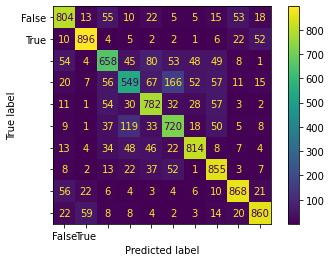

In [15]:
import cv2
import os
import sys
import glob
import random
from skimage import data, exposure, img_as_float
import matplotlib.pyplot as plt
import numpy as np
import time
from torchvision.transforms import ToTensor
import argparse
import shutil
import string
import math as m
from sklearn.metrics import confusion_matrix
from sklearn import metrics as metrics
from tqdm.notebook import tqdm
import torch

def SetupAll():
    """
    Outputs:
    ImageSize - Size of the Image
    """   
    # Image Input Shape
    ImageSize = [32, 32, 3]

    return ImageSize

def StandardizeInputs(Img):
    ##########################################################################
    # Add any standardization or cropping/resizing if used in Training here!
    ##########################################################################
    return Img
    
def prediction(model,img,dvc):
    # This method predicts one image at a time

    # since the data is trained on GPU, use GPU for prediction as well
    data = to_device(img.unsqueeze(0),dvc) #extra dim, batch size = 1
    predicted =model(data)
    (_,predicted_label) = torch.max(predicted,dim=1)
    predicted_class = CLASSES[predicted_label[0].item()]
    return predicted_class, predicted_label.tolist()[0]

def convertToOneHot(lb,NumClasses=10):
    """
    InputS: lb - label, NUMBER OF CLASSES
    Output: One hot vector
    """
    return np.eye(10)[lb]

def Accuracy(gt, plabel):
    """
    Inputs: 
    ground truth and label predicted
    Outputs:
    Accuracy in percentage
    """
    # accuracy_metric = percentage of corrct prediction
    right = 0
    wrong = 0 
    for i in tqdm(range(len(gt))):
      if plabel[i]==gt[i]:
        right+=1
      else:
        wrong+=1
    accuracy = (right/(right+wrong))*100
   
    return accuracy


def ConfusionMatrix(LabelsTrue, LabelsPred):
    """
    LabelsTrue - True labels
    LabelsPred - Predicted labels
    """

    # Get the confusion matrix using sklearn.

    confusion_matrix = metrics.confusion_matrix(LabelsTrue, LabelsPred)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
    cm_display.plot()
    plt.show() 

            

def TestOperation(model):
    """
    Inputs: 
    ImageSize is the size of the image
    ModelPath - Path to load trained model from
    TestSet - The test dataset
    LabelsPathPred - Path to save predictions
    Outputs:
    Predictions written to /content/data/TxtFiles/PredOut.txt
    """
    #save the trained model to the directory using torch.save()
    torch.save(model.state_dict(),'CIFAR10_simplecnn.pth')

    # we can load the model from the save to GPU again
    device = get_default_device() 
    Model =to_device(CIFAR10Model(), device)
    Model.load_state_dict(torch.load('CIFAR10_simplecnn.pth'))
    
    # Test dataset
    test_dataset = ImageFolder(path+'/test', transform=ToTensor())
    # Normalizing the dataset
    normalize = transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    sz = len(test_dataset)
    normal = []
    for i in tqdm(range(sz)):
      norm = (normalize(test_dataset[i][0]))
      normal.append(norm)
    normalized = []
    for i in tqdm(range(sz)):
      ds = normal[i],test_dataset[i][1]
      normalized.append(ds)
    test_dataset = normalized

    gt = []
    plabel = []
    for idx in tqdm(range(len(test_dataset))):
      img, label = test_dataset[idx]
      gt.append(label)
      _,predicted_label = prediction(model,img,device)
      plabel.append(predicted_label)

    # Test accuracy
    accuracy = Accuracy(gt,plabel)
    print("Test  set accuracy: ",round(accuracy,3),"%", "\n")
    print("The confusion matrix is printed below")
    ConfusionMatrix(gt, plabel)  
    
   
    
TestOperation(model)
  
